# Example - KNN in kernel fisher space

이번 튜토리얼에서는 mply 패키지를 이용한 KFDA의 예제와 matplotlib 패키지를 이용한 시각화를 보여드리고자 합니다. Kernel Fisher Discriminant Analysis를 활용하여 K-Nearest Neighbors (KNN) 분석을 하는 것을 보여드리겠습니다.

## 1. 패키지 선언

일단 필요한 패키지들을 불러옵니다.
- numpy: 파이썬 내 행렬연산을 돕기 위한 패키지
- matplotlib: 그래프로 시각화하기 위해 사용하는 패키지
- mlpy: KFDA뿐 아니라 least squares, ridge regression, SVM, KNN, clustering 등 다양한 기계학습 기법들을 쉽게 쓰도록 하기 위한 패키지

패키지 선언은 아래처럼 

   import "패키지명" (as "줄임")
   
으로 사용합니다. "줄임" 을 쓰는 것은 코드 내에서 패키지의 함수를 선언할 때마다 풀네임을 치기 번거로워서입니다.

가장 윗 줄의 **%pylab inline**은 ipython notebook 특성상 matplotlib을 이용한 그래프를 그릴 때 실시간으로 ipynb 화면에 출력될 수 있도록 합니다. 이를 사용하지 않을 시 에러가 납니다.

In [1]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlpy

Populating the interactive namespace from numpy and matplotlib


## 2. 데이터 생성

1) 난수 생성

In [2]:
np.random.seed(0)

2) 데이터 생성

첫번째 카테고리에 해당하는 데이터를 생성하고자 합니다. 이 때 어떤 분포의 데이터를 만들 것인지를 미리 설정합니다
- 분포의 평균(mean1) = 1, 4.5
- 분포의 공분산(cov11) = [1,1] , [1,2]
- 분포에서 추출할 샘플 개수 = 20

In [3]:
mean1, cov1, n1 = [1, 4.5], [[1,1],[1,2]], 20  # 20 samples of class 1

numpy 패키지의 random.multivariate_normal() 함수는 위에서 설정한 mean, cov, n을 받아서 해당 분포를 따르는 샘플들을 랜덤으로 생성합니다. 이를 x1에 저장합니다. 보다시피 20개의 샘플이 생성되었습니다.

In [4]:
x1 = np.random.multivariate_normal(mean1, cov1, n1)
x1

array([[-0.71096765,  2.2020092 ],
       [-1.01067153,  3.88099307],
       [-0.07485433,  1.61199012],
       [ 0.27137971,  3.14313654],
       [ 0.87193879,  4.7754801 ],
       [ 0.11291239,  4.77426314],
       [ 0.2886543 ,  3.49205604],
       [ 0.44700441,  3.99749203],
       [-0.16308149,  2.37691662],
       [ 1.18271341,  3.79158675],
       [ 2.82807522,  8.22626258],
       [ 0.65484589,  3.06906161],
       [-0.16616332,  0.90339872],
       [ 1.05948385,  4.37619908],
       [-1.0763475 ,  2.86773401],
       [ 0.66938205,  4.40960562],
       [ 2.79656199,  5.07833247],
       [ 1.21375423,  5.02966085],
       [-0.67867626,  3.19732705],
       [ 1.48840983,  4.93488551]])

y1에는 해당 카테고리 레이블(label)이 저장됩니다. 이들이 1번 카테고리라는 것을 의미하기 위해 해당 샘플개수만큼 1을 저장합니다.

In [5]:
y1 = np.ones(n1, dtype=np.int)
y1

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

두번째 카테고리의 데이터도 이런 방식으로 생성합니다.

In [6]:
mean2, cov2, n2 = [2.5, 2.5], [[1,1],[1,2]], 30 # 30 samples of class 2
x2 = np.random.multivariate_normal(mean2, cov2, n2)
y2 = 2 * np.ones(n2, dtype=np.int)

이제 x1과 x2, y1과 y2를 각각 합쳐 양쪽 카테고리의 데이터가 다 들어간 x와 y를 만듭니다. numpy 패키지의 concatenate() 함수를 이용하여 두 개의 array들을 하나로 합친 다음, 각각 x와 y에 저장합니다.
- x = np.concatenate((x1, x2), axis=0)의 경우, x1와 x2는 합쳐질 array들이고 각각 [20,2]의 크기를 가집니다. axis=0은 이들을 1번 축 기준으로 합친다는 뜻인데, 즉 [20,2]와 [30,2]를 합쳐 [40,2]를 생성한다는 뜻입니다. axis=1로 놓을 경우 가로축으로 합쳐지는데, 이는 우리가 원하는 결과가 아님을 알 수 있습니다.

In [7]:
x = np.concatenate((x1, x2), axis=0) # concatenate the samples
y = np.concatenate((y1, y2))

In [8]:
df = pd.read_csv('phy_train.dat', sep='\s+', header=None, skiprows=0)
arr = df.as_matrix()

## 3. 모델 생성

이제 mlpy 패키지 내의 KFDA 클래스를 생성하고, 이 클래스의 함수들을 이용하여 필요한 연산을 할겁니다. 우선 우리가 사용할 KFDA 모델에서 어떤 커널 함수가 사용될 지를 정의합니다. 사용할 수 있는 커널 함수들은 다음과 같습니다. (http://mlpy.sourceforge.net/docs/3.5/kernel.html#functions 참조)
- Linear kernel
- Polynomial kernel
- Gaussian kernel
- Exponential kernel
- Sigmoid kernel

여기에서는 Gaussian kernel을 사용하겠습니다. K에는 x에다 아래와 같은 함수를 적용했을 시의 값이 저장됩니다.

In [8]:
from IPython.display import display, Math, Latex
display(Math(r'K = e^{-||t_i-x_j||^2/ 2 \sigma^2}'))

<IPython.core.display.Math object>

In [9]:
K = mlpy.kernel_gaussian(x, x, sigma=1) # compute the kernel matrix

# 위 줄을 주석처리하고 아래에 있는 주석들 중 하나를 지워서 다른 커널을
# 사용하셔도 좋습니다

# K = mlpy.kernel_linear(x, x) # Linear kernel
# K = mlpy.kernel_polynomial(x, x, gamma=1.0) # Polynomial kernel
# K = mlpy.kernel_sigmoid(x, x, gamma=1.0) # Linear kernel

K는 50개의 값에 대한 각각의 gaussian distance를 계산한 diagonal matrix임을 알 수 있습니다.

In [10]:
print K.shape # K의 모양
K # K에 저장된 결과값

(50, 50)


array([[ 1.        ,  0.23353937,  0.68634055, ...,  0.04006548,
         0.053184  ,  0.0148001 ],
       [ 0.23353937,  1.        ,  0.04919004, ...,  0.00465621,
         0.02688021,  0.00222537],
       [ 0.68634055,  0.04919004,  1.        , ...,  0.13505333,
         0.09251164,  0.05502913],
       ..., 
       [ 0.04006548,  0.00465621,  0.13505333, ...,  1.        ,
         0.68450313,  0.91701033],
       [ 0.053184  ,  0.02688021,  0.09251164, ...,  0.68450313,
         1.        ,  0.68147466],
       [ 0.0148001 ,  0.00222537,  0.05502913, ...,  0.91701033,
         0.68147466,  1.        ]])

이제 kfda라는 이름의 KFDA 클래스를 생성합니다. 파라미터로는 lambda값만 받겠습니다.

In [11]:
kfda = mlpy.KFDA(lmb=0.01)

생성되기만 하고 아무 값도 안 저장되어 있는 이 커널 클래스에, gaussian function을 적용한 결과 K와 각 값의 클래스 y를 인자로 주고, 학습을 시킵니다. KFDA의 learn 함수는 인자들을 토대로 transformation vector를 학습합니다.

In [12]:
kfda.learn(K, y) # compute the transformation vector

이제 이 K를 1차원의 저차원 공간으로 embedding합니다. 이 때에는 KFDA 패키지의 transform 함수를 사용하여 결과를 z에 저장합니다. matplotlib(plt로 선언)을 이용해서 우리의 kernel fisher space에 있는 값들이 분류가 잘 되어있는지 색깔로 확인합니다.

In [13]:
z = kfda.transform(K) # embedded x into the kernel fisher space

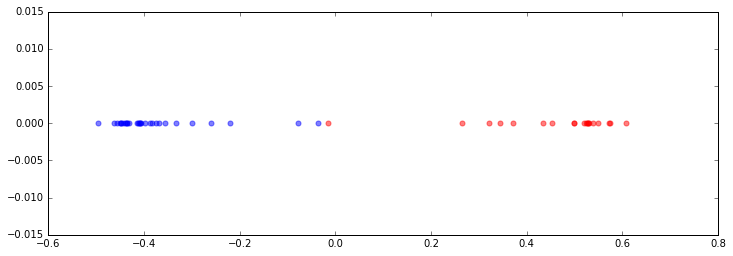

In [14]:
plt.figure(figsize=(12,4))
tmp=np.zeros((len(z),1))
plt.scatter(z[y==1], tmp[y==1], marker = '.', color = 'r', alpha = 0.5, s = 100)
plt.scatter(z[y==2], tmp[y==2], marker = '.', color = 'b', alpha = 0.5, s = 100)

## 4. Plotting classifier region with K-Nearest Neighbor

우리가 만든 kernel fisher space가 2차원에서는 어떤 영역을 나타내는지를 표현하기 위해 현존하는 classifier를 사용해야 하기 때문에, KNN(K-Nearest Neighbors) 알고리즘을 사용합니다. mlpy 패키지 내의 다른 클래스, KNN을 사용하겠습니다. KFDA와 사용법이 비슷한데, 우선 KNN 클래스를 선언하고, nearest neighbors의 개수 n을 파라미터로 넣습니다. 선언된 클래스는 knn에 저장됩니다.

In [15]:
knn = mlpy.KNN(k=5)

아까 우리가 kernel fisher space에 임베딩 되어있는 샘플들(=z)과 각 샘플의 카테고리(=y)를 가지고 KNN을 학습합니다. 이 때 z와 y를 인자로 받는 learn()이라는 함수를 사용합니다.

In [16]:
knn.learn(z, y) # learn KNN in the kernel fisher space

우선 화면에 나타내야 할 x랑 y의 범위를 지정합니다. min() 함수와 max() 함수를 이용하여 x와 y의 최대값을 각각 계산합니다. np.meshrid([a,b,c])함수는 a에서 b까지 c의 간격만큼 숫자가 저장된 벡터를 반환하는데, 이걸로 x축과 y축에 걸쳐 그래프에서 사용될 점들을 만듭니다.

In [17]:
xmin, xmax = x[:,0].min()-1, x[:,0].max()+1
ymin, ymax = x[:,1].min()-1, x[:,1].max()+1
xx, yy = np.meshgrid(np.arange(xmin, xmax, 0.05), np.arange(ymin, ymax, 0.05))

In [18]:
print "xmin: ",xmin
print "xmax: ",xmax 
print "ymin: ",ymin 
print "ymax: ",ymax 
print "Number of points:", xx.shape

xmin:  -2.07634749792
xmax:  5.13850003668
ymin:  -0.469469732828
ymax:  9.22626258114
Number of points: (194, 145)


In [19]:
xt = np.c_[xx.ravel(), yy.ravel()]
xt[0:10]

array([[-2.0763475 , -0.46946973],
       [-2.0263475 , -0.46946973],
       [-1.9763475 , -0.46946973],
       [-1.9263475 , -0.46946973],
       [-1.8763475 , -0.46946973],
       [-1.8263475 , -0.46946973],
       [-1.7763475 , -0.46946973],
       [-1.7263475 , -0.46946973],
       [-1.6763475 , -0.46946973],
       [-1.6263475 , -0.46946973]])

이 점들 역시 아까와 동일한 커널을 이용해서 아까의 kfda 모델을 통해 학습한 kernel fisher space에 투영합니다.

In [20]:
Kt = mlpy.kernel_gaussian(xt, x, sigma=1) # compute the kernel matrix Kt

# 역시 위에서 kernel을 바꿨다면 다음 함수도 위에와 동일하게끔 바꿔줘야 합니다.
# Kt = mlpy.kernel_linear(xt, x) # Linear kernel
# Kt = mlpy.kernel_polynomial(xt, x, gamma=1.0) # Polynomial kernel
# Kt = mlpy.kernel_sigmoid(xt, x, gamma=1.0) # Linear kernel

zt = kfda.transform(Kt) # embedded xt into the kernel fisher space

이 투영한 값들을 가지고 1차원에서 knn을 통해 어떤 그룹에 속하는지를 계산한 다음, 1차원에서 원래 차원으로 재배치합니다.

In [21]:
yt = knn.pred(zt).reshape(xx.shape) # predict class of points in kernel fisher space

이 자료들을 갖고 원래의 점들과 classifier의 구분 영역을 모두 출력합니다.

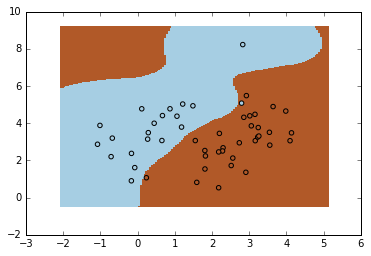

In [22]:
plt.figure(1)
cmap = plt.set_cmap(plt.cm.Paired)
plot1 = plt.pcolormesh(xx, yy, yt)
plot2 = plt.scatter(x[:,0], x[:,1], c=y)
plt.show()